In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, precision_recall_curve

In [16]:
data_dir = "data"

In [17]:
# Define column names based on the dataset documentation
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

network_data = pd.read_csv(f"{data_dir}/kddcup.data.corrected", names=column_names, header=None)

In [18]:
print(network_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898431 entries, 0 to 4898430
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   duration                     int64  
 1   protocol_type                object 
 2   service                      object 
 3   flag                         object 
 4   src_bytes                    int64  
 5   dst_bytes                    int64  
 6   land                         int64  
 7   wrong_fragment               int64  
 8   urgent                       int64  
 9   hot                          int64  
 10  num_failed_logins            int64  
 11  logged_in                    int64  
 12  num_compromised              int64  
 13  root_shell                   int64  
 14  su_attempted                 int64  
 15  num_root                     int64  
 16  num_file_creations           int64  
 17  num_shells                   int64  
 18  num_access_files             int64  
 19  

In [19]:
# Count missing values in each column
missing_values = network_data.isnull().sum()

print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [20]:
# Get the distribution of label data that shows there are many more anomalies than "normal" data
network_data["label"].value_counts()

label
smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: count, dtype: int64

In [21]:
# Get the distribution of service data
network_data["service"].value_counts()

service
ecr_i        2811660
private      1100831
http          623091
smtp           96554
other          72653
              ...   
tftp_u             3
harvest            2
aol                2
http_8001          2
http_2784          1
Name: count, Length: 70, dtype: int64

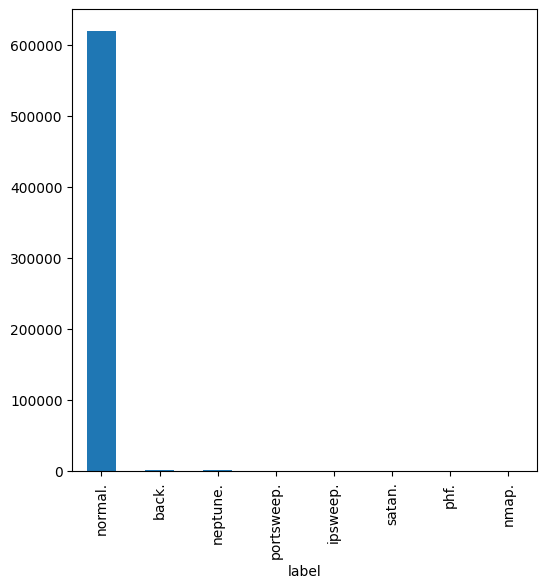

In [22]:
# Focus only on the http service data for anomaly detection for now
network_data_http = network_data[network_data["service"] == "http"]
network_data_http["label"].value_counts().plot(kind='bar', figsize=(6,6))
plt.show()

In [34]:
# Get the data labeled normal for training the VAE
normal_http_data = network_data_http[network_data_http["label"] == "normal."].drop(columns="label")

# One hot encode the categorical features
categorical_cols = ["protocol_type", "service", "flag"]
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_categories = encoder.fit_transform(normal_http_data[categorical_cols])

In [24]:
# Standardize numerical features
numerical_cols = normal_http_data.drop(columns=categorical_cols).columns
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(normal_http_data[numerical_cols])

In [35]:
# Combine the encoded and standardized data
combined_data = np.hstack([scaled_numerical_data, encoded_categories])
print(combined_data.shape)

(619046, 49)


In [36]:
# Create the train/validation/test data (80/10/10)
train_data, temp_data = train_test_split(combined_data, test_size=0.2, random_state=42)
val_data, _ = train_test_split(temp_data, test_size=0.5, random_state=42)

In [37]:
# VAE class
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=8, dropout_prob=0.2):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )

        # Latent space
        self.mu_layer = nn.Linear(16, latent_dim)  
        self.logvar_layer = nn.Linear(16, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # Assumes inputs normalized between 0 and 1
        )
        
    # Keep the latent space stochastic, preventing the VAE from collapsing into a deterministic autoencoder
    def reparameterize(self, mu, logvar):
        # Convert log variance to standard deviation
        std = torch.exp(0.5 * logvar)
        # Random sample from standard normal
        eps = torch.randn_like(std)

        # Shift and scale eps to match the desired distribution
        return mu + eps * std

    def forward(self, x):
        # Encode the input data
        hidden = self.encoder(x)
        mu, logvar = self.mu_layer(hidden), self.logvar_layer(hidden)
        
        # Sample latent vector
        z = self.reparameterize(mu, logvar)

        # Decode the latent representation
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

    def loss_function(self, x, reconstructed_x, mu, logvar):
        # Calculate the reconstruction loss (MSE)
        reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')

        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return reconstruction_loss + kl_loss

In [38]:
# Convert numpy arrays to pytorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)

In [40]:
# Define hyperparameters
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.0001
decay = 0.001
num_epochs = 50

input_dimensions = train_data.shape[1]
latent_dimensions = 8
vae = VAE(input_dimensions, latent_dimensions).to(device)

optimizer = optim.AdamW(vae.parameters(), lr=learning_rate, weight_decay=decay)
# Reduce LR in half if val loss doesn't decrease for 4 straight epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.5)
criterion = vae.loss_function

In [41]:
# Create DataLoaders, don't need Test DataLoader b/c have a csv with test data
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size)

In [42]:
best_model_path = "best_vae_model.pth"
best_val_loss = float("inf")

all_train_loss = []
all_val_loss = []

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}: Learning Rate: {optimizer.param_groups[0]['lr']}")
    vae.train()
    train_loss = 0.0

    for batch in train_loader:
        x = batch[0].to(device)

        optimizer.zero_grad()
        # Get the decoded latent representation, the mean and log variance
        reconstructed_x, mu, logvar = vae(x)

        loss = criterion(x, reconstructed_x, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
   
    vae.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            reconstructed_x, mu, logvar = vae(x)

            loss = criterion(x, reconstructed_x, mu, logvar)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)

    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print("New best model saved.")
        torch.save(vae.state_dict(), best_model_path)

Epoch 1: Learning Rate: 0.0001
Epoch [1/50] - Train Loss: 469.5264 | Val Loss: 449.6730
New best model saved.
Epoch 2: Learning Rate: 0.0001
Epoch [2/50] - Train Loss: 450.0423 | Val Loss: 443.0891
New best model saved.
Epoch 3: Learning Rate: 0.0001
Epoch [3/50] - Train Loss: 444.1763 | Val Loss: 440.1686
New best model saved.
Epoch 4: Learning Rate: 0.0001
Epoch [4/50] - Train Loss: 442.1757 | Val Loss: 440.1972
Epoch 5: Learning Rate: 0.0001
Epoch [5/50] - Train Loss: 441.1541 | Val Loss: 444.9561
Epoch 6: Learning Rate: 0.0001
Epoch [6/50] - Train Loss: 440.5141 | Val Loss: 440.0340
New best model saved.
Epoch 7: Learning Rate: 0.0001
Epoch [7/50] - Train Loss: 440.2715 | Val Loss: 439.7525
New best model saved.
Epoch 8: Learning Rate: 0.0001
Epoch [8/50] - Train Loss: 439.9226 | Val Loss: 439.8567
Epoch 9: Learning Rate: 0.0001
Epoch [9/50] - Train Loss: 439.6502 | Val Loss: 439.7026
New best model saved.
Epoch 10: Learning Rate: 0.0001
Epoch [10/50] - Train Loss: 439.4691 | Val L

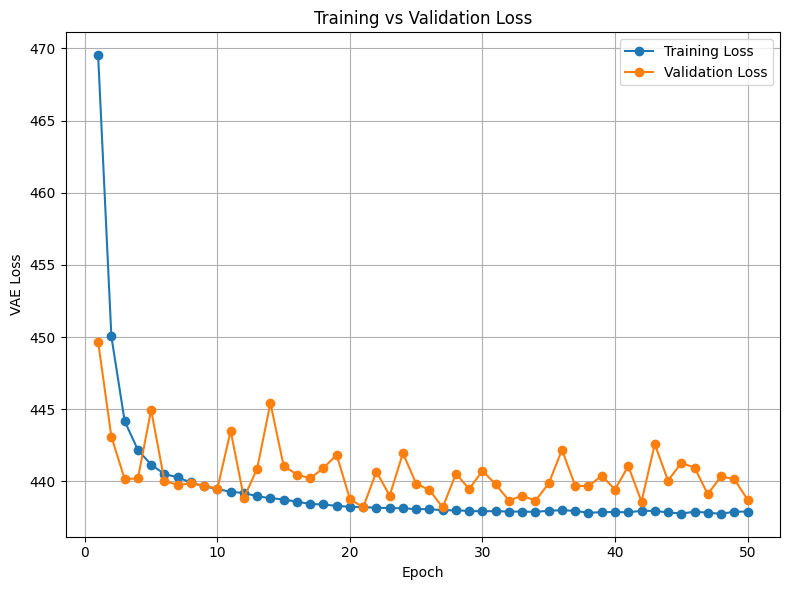

In [44]:
# Plot the loss and F1 score vs training epoch
epochs = range(1, len(all_train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, all_train_loss, label='Training Loss', marker='o')
plt.plot(epochs, all_val_loss, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('VAE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
# Read in the separate test data file
test_data = pd.read_csv(f"{data_dir}/corrected/corrected", names=column_names, header=None)
print(test_data["label"].value_counts())

label
smurf.              164091
normal.              60593
neptune.             58001
snmpgetattack.        7741
mailbomb.             5000
guess_passwd.         4367
snmpguess.            2406
satan.                1633
warezmaster.          1602
back.                 1098
mscan.                1053
apache2.               794
processtable.          759
saint.                 736
portsweep.             354
ipsweep.               306
httptunnel.            158
pod.                    87
nmap.                   84
buffer_overflow.        22
multihop.               18
named.                  17
sendmail.               17
ps.                     16
rootkit.                13
xterm.                  13
teardrop.               12
xlock.                   9
land.                    9
xsnoop.                  4
ftp_write.               3
loadmodule.              2
perl.                    2
udpstorm.                2
worm.                    2
phf.                     2
sqlattack.            

In [51]:
# Get the http service data and separate into normal/anomalous
test_http_data = test_data[test_data["service"] == "http"]
# Separate into normal and anomalous
normal_test_http = test_http_data[test_http_data["label"] == "normal."].drop(columns="label")
anomalous_test_http = test_http_data[test_http_data["label"] != "normal."].drop(columns="label")

In [52]:
# Transform normal test data (without refitting)
normal_test_encoded = encoder.transform(normal_test_http[categorical_cols])
normal_test_scaled = scaler.transform(normal_test_http[numerical_cols])
normal_test_transformed = np.hstack([normal_test_scaled, normal_test_encoded])

# Transform anomalous test data (without refitting)
anomalous_test_encoded = encoder.transform(anomalous_test_http[categorical_cols])
anomalous_test_scaled = scaler.transform(anomalous_test_http[numerical_cols])
anomalous_test_transformed = np.hstack([anomalous_test_scaled, anomalous_test_encoded])

In [62]:
print(normal_test_transformed.shape, anomalous_test_transformed.shape)

(39247, 49) (1990, 49)


In [54]:
# Run data through the VAE and get the associated reconstruction error
def compute_reconstruction_error(vae, data):
    data_tensor = torch.tensor(data, dtype=torch.float32)

    with torch.no_grad():
        reconstructed, _, _ = vae(data_tensor)
    
    errors = torch.mean((data_tensor - reconstructed) ** 2, dim=1)

    return errors.detach().cpu().numpy()

In [55]:
# Load the best performing model from training
vae.load_state_dict(torch.load(best_model_path, weights_only=True))
normal_errors = compute_reconstruction_error(vae, normal_test_transformed)
anomalous_errors = compute_reconstruction_error(vae, anomalous_test_transformed)

In [56]:
# Create labels (1 for anomalies, 0 for normal) from test data
y_true = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(anomalous_errors))])
# Get outputs from trained VAE
y_scores = np.concatenate([normal_errors, anomalous_errors])  

Best Threshold: 69.2557 (Max F1-Score: 0.9598)


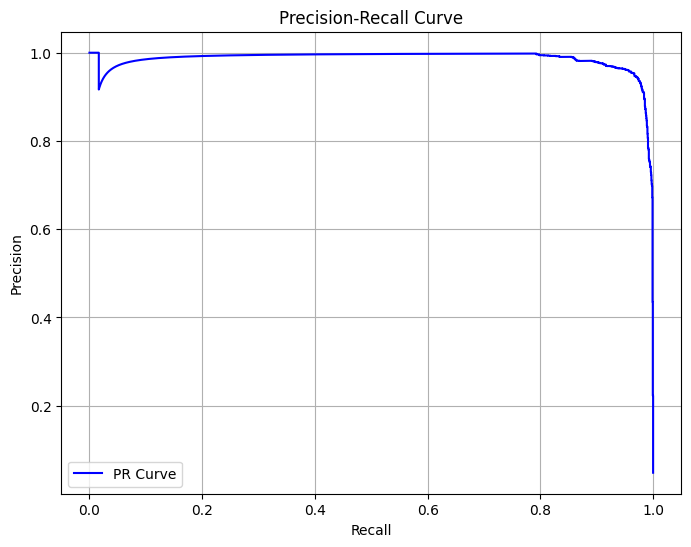

In [58]:
# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10) # Add 1e-10 to avoid div by zero

# Find the threshold with the max F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f} (Max F1-Score: {f1_scores[best_idx]:.4f})")

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

In [63]:
# Use the highest performing threshold from the PR curve
y_pred = y_scores > best_threshold  

# Compute precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

Precision: 0.9529, Recall: 0.9663, F1-Score: 0.9596
